### Load libraries 

In [1]:
import xml.etree.ElementTree as ET
from datetime import datetime
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from bson import ObjectId


### Parsing XML file and extracting data related to only 2021 ( Extraction phase of ETL)

In [2]:
xml_file_path = 'Crime_Data.xml'  

# Function to check if the reported date has year 2021 
def is_reported_in_required_years(date_str):
    try:
        # Converting the date string into a datetime object
        date_obj = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")
        # Checking if the year is 2021
        return date_obj.year in [2021]
    except ValueError as e:
        print(f"Error parsing date {date_str}: {e}")
        return False

# Parsing the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Storing extracted data in a list
extracted_data = []

for row in root.findall('.//row'):
    # Extracting date_rptd 
    date_rptd_str = row.find('date_rptd').text if row.find('date_rptd') is not None else None
    
    # Skipping the record if date_rptd is not present
    if date_rptd_str is None:
        continue
    
    # Checking if the reported date is within 2021
    if is_reported_in_required_years(date_rptd_str):
        # Dictionary for the data to be extracted
        data_dict = {elem.tag: elem.text for elem in row}
        extracted_data.append(data_dict)
       


### MongoDB connection and data insertion

In [3]:
# Connecting to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["crimedatabase"]
collection = db["crimereports"]
# Inserting data into MongoDB
collection.insert_many(extracted_data)
print(f"Inserted {len(extracted_data)} records into MongoDB")

Inserted 208283 records into MongoDB


In [4]:
client = MongoClient("mongodb://localhost:27017/")
db = client["crimedatabase"]
coll = db["crimereports"]

for doc in coll.find().limit(20):
    print(doc)

{'_id': ObjectId('6560da1421e317d69e7a32dd'), 'dr_no': '211916029', 'date_rptd': '2021-11-26T00:00:00', 'date_occ': '2020-11-30T00:00:00', 'time_occ': '0730', 'area': '19', 'area_name': 'Mission', 'rpt_dist_no': '1916', 'part_1_2': '2', 'crm_cd': '626', 'crm_cd_desc': 'INTIMATE PARTNER - SIMPLE ASSAULT', 'mocodes': '2000 1814 0416', 'vict_age': '24', 'vict_sex': 'F', 'vict_descent': 'H', 'premis_cd': '501', 'premis_desc': 'SINGLE FAMILY DWELLING', 'weapon_used_cd': '400', 'weapon_desc': 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)', 'status': 'IC', 'status_desc': 'Invest Cont', 'crm_cd_1': '626', 'location': '14200    BERG                         ST', 'lat': '34.3055', 'lon': '-118.4439'}
{'_id': ObjectId('6560da1421e317d69e7a32de'), 'dr_no': '210916801', 'date_rptd': '2021-11-22T00:00:00', 'date_occ': '2020-11-19T00:00:00', 'time_occ': '1200', 'area': '09', 'area_name': 'Van Nuys', 'rpt_dist_no': '0932', 'part_1_2': '2', 'crm_cd': '354', 'crm_cd_desc': 'THEFT OF IDENTITY', 'mocodes

### Retrieving data from MongoDB and storing in a dataframe

In [5]:
batch_size = 1000
cursor = collection.find()
batch_data = []
df_list = []
total_processed = 0  # Initializing a counter for total documents to be processed

while True:
    try:
        doc = cursor.next()
        batch_data.append(doc)
        if len(batch_data) == batch_size:
            df_list.append(pd.DataFrame(batch_data))
            total_processed += len(batch_data)  
            print(f"Processed {len(batch_data)} documents in the current batch.")
            batch_data = []
    except StopIteration:
        break

# Processing remaining documents
if batch_data:
    df_list.append(pd.DataFrame(batch_data))
    total_processed += len(batch_data) 

# Combining all dataframes
df = pd.concat(df_list, ignore_index=True)

client.close()

# Printing the total number of documents processed
print(f"Total number of documents processed: {total_processed}")

Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 1000 documents in the current batch.
Processed 100

### Data cleaning ( Transformation phase of ETL)

In [6]:
# Checking missing values
print(df.isnull().sum())


_id                     0
dr_no                   0
date_rptd               0
date_occ                0
time_occ                0
area                    0
area_name               0
rpt_dist_no             0
part_1_2                0
crm_cd                  0
crm_cd_desc             0
mocodes            716577
vict_age                0
vict_sex           683724
vict_descent       683763
premis_cd              72
premis_desc          2388
weapon_used_cd    3300744
weapon_desc       3300744
status                  0
status_desc             0
crm_cd_1               51
location                0
lat                     0
lon                     0
crm_cd_2          4692777
cross_street      4218057
crm_cd_3          5066196
crm_cd_4          5078727
dtype: int64


In [7]:
# Handling missing values in crm_cd_1
df['crm_cd_1'].fillna(df['crm_cd_1'].mode()[0], inplace=True)

In [8]:
# Categorizing missing values in vict_sex and vict_descent as Unknown
df['vict_sex'].fillna('Unknown', inplace=True)
df['vict_descent'].fillna('Unknown', inplace=True)

In [9]:
columns_to_fill = ['premis_cd', 'premis_desc', 'mocodes', 'weapon_used_cd', 'weapon_desc', 
                   'crm_cd_2', 'cross_street', 'crm_cd_3', 'crm_cd_4']

# Filling missing values with Unknown
for column in columns_to_fill:
    df[column].fillna('Unknown', inplace=True)

In [10]:
print(df.isnull().sum())

_id               0
dr_no             0
date_rptd         0
date_occ          0
time_occ          0
area              0
area_name         0
rpt_dist_no       0
part_1_2          0
crm_cd            0
crm_cd_desc       0
mocodes           0
vict_age          0
vict_sex          0
vict_descent      0
premis_cd         0
premis_desc       0
weapon_used_cd    0
weapon_desc       0
status            0
status_desc       0
crm_cd_1          0
location          0
lat               0
lon               0
crm_cd_2          0
cross_street      0
crm_cd_3          0
crm_cd_4          0
dtype: int64


In [11]:
# Converting date strings to datetime objects
df['date_rptd'] = pd.to_datetime(df['date_rptd'])
df['date_occ'] = pd.to_datetime(df['date_occ'])

In [12]:
inconsistencies = df[df['date_rptd'] < df['date_occ']]
print(f"Inconsistent Dates: {len(inconsistencies)}")

Inconsistent Dates: 0


In [13]:
# Converting lat and lon columns to float
df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
df['lon'] = pd.to_numeric(df['lon'], errors='coerce')

# Performing the validation check
invalid_coords = df[(df['lat'] < -90) | (df['lat'] > 90) | (df['lon'] < -180) | (df['lon'] > 180)]
print(f"Invalid Coordinates: {len(invalid_coords)}")

Invalid Coordinates: 0


In [14]:
# Extracting day of week, month, and year from date_occ
df['day_of_week'] = df['date_occ'].dt.day_name()
df['month'] = df['date_occ'].dt.month
df['year'] = df['date_occ'].dt.year

In [15]:
# Handling missing values
df['vict_age'] = df['vict_age'].replace(0, np.nan)
df['vict_age'].fillna(df['vict_age'].median(), inplace=True)

In [16]:
print(df.dtypes)

_id                       object
dr_no                     object
date_rptd         datetime64[ns]
date_occ          datetime64[ns]
time_occ                  object
area                      object
area_name                 object
rpt_dist_no               object
part_1_2                  object
crm_cd                    object
crm_cd_desc               object
mocodes                   object
vict_age                  object
vict_sex                  object
vict_descent              object
premis_cd                 object
premis_desc               object
weapon_used_cd            object
weapon_desc               object
status                    object
status_desc               object
crm_cd_1                  object
location                  object
lat                      float64
lon                      float64
crm_cd_2                  object
cross_street              object
crm_cd_3                  object
crm_cd_4                  object
day_of_week               object
month     

In [17]:
df['time_occ'] = df['time_occ'].astype(str).str.zfill(4)  # Pad with zeros if necessary

# Convert to datetime using the correct format
df['time_occ'] = pd.to_datetime(df['time_occ'], format='%H%M')

# Extract hour
df['hour'] = df['time_occ'].dt.hour


In [18]:
numerical_columns = ['vict_age', 'area', 'rpt_dist_no', 'part_1_2', 'crm_cd', 'premis_cd', 'weapon_used_cd', 'crm_cd_1', 'crm_cd_2', 'crm_cd_3', 'crm_cd_4']
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 
    
# Handling invalid vict_age values
df['vict_age'] = pd.to_numeric(df['vict_age'], errors='coerce')  # Convert to numeric, set invalid parsing as NaN
df.loc[df['vict_age'] < 0, 'vict_age'] = None  # Replace negative ages with NaN
df['vict_age'].fillna(df['vict_age'].median(), inplace=True)  # Replace NaN with median age

# Converting numerical codes to categorical
categorical_columns = ['area', 'rpt_dist_no', 'part_1_2', 'crm_cd', 'premis_cd', 'weapon_used_cd']
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [19]:
# Converting columns to category
categorical_columns = ['area_name', 'vict_sex', 'vict_descent', 'premis_desc', 'weapon_desc', 'status', 'status_desc', 'day_of_week']
for col in categorical_columns:
    df[col] = df[col].astype('category')
# Converting crime codes to categorical
df['crm_cd_1'] = df['crm_cd_1'].astype('category')
df['crm_cd_2'] = df['crm_cd_2'].astype('category')
df['crm_cd_3'] = df['crm_cd_3'].astype('category')
df['crm_cd_4'] = df['crm_cd_4'].astype('category')

# Handling invalid lon and lat values
df['lon'].replace(0, np.nan, inplace=True)
df['lat'].replace(0, np.nan, inplace=True)
df.dropna(subset=['lon', 'lat'], inplace=True)

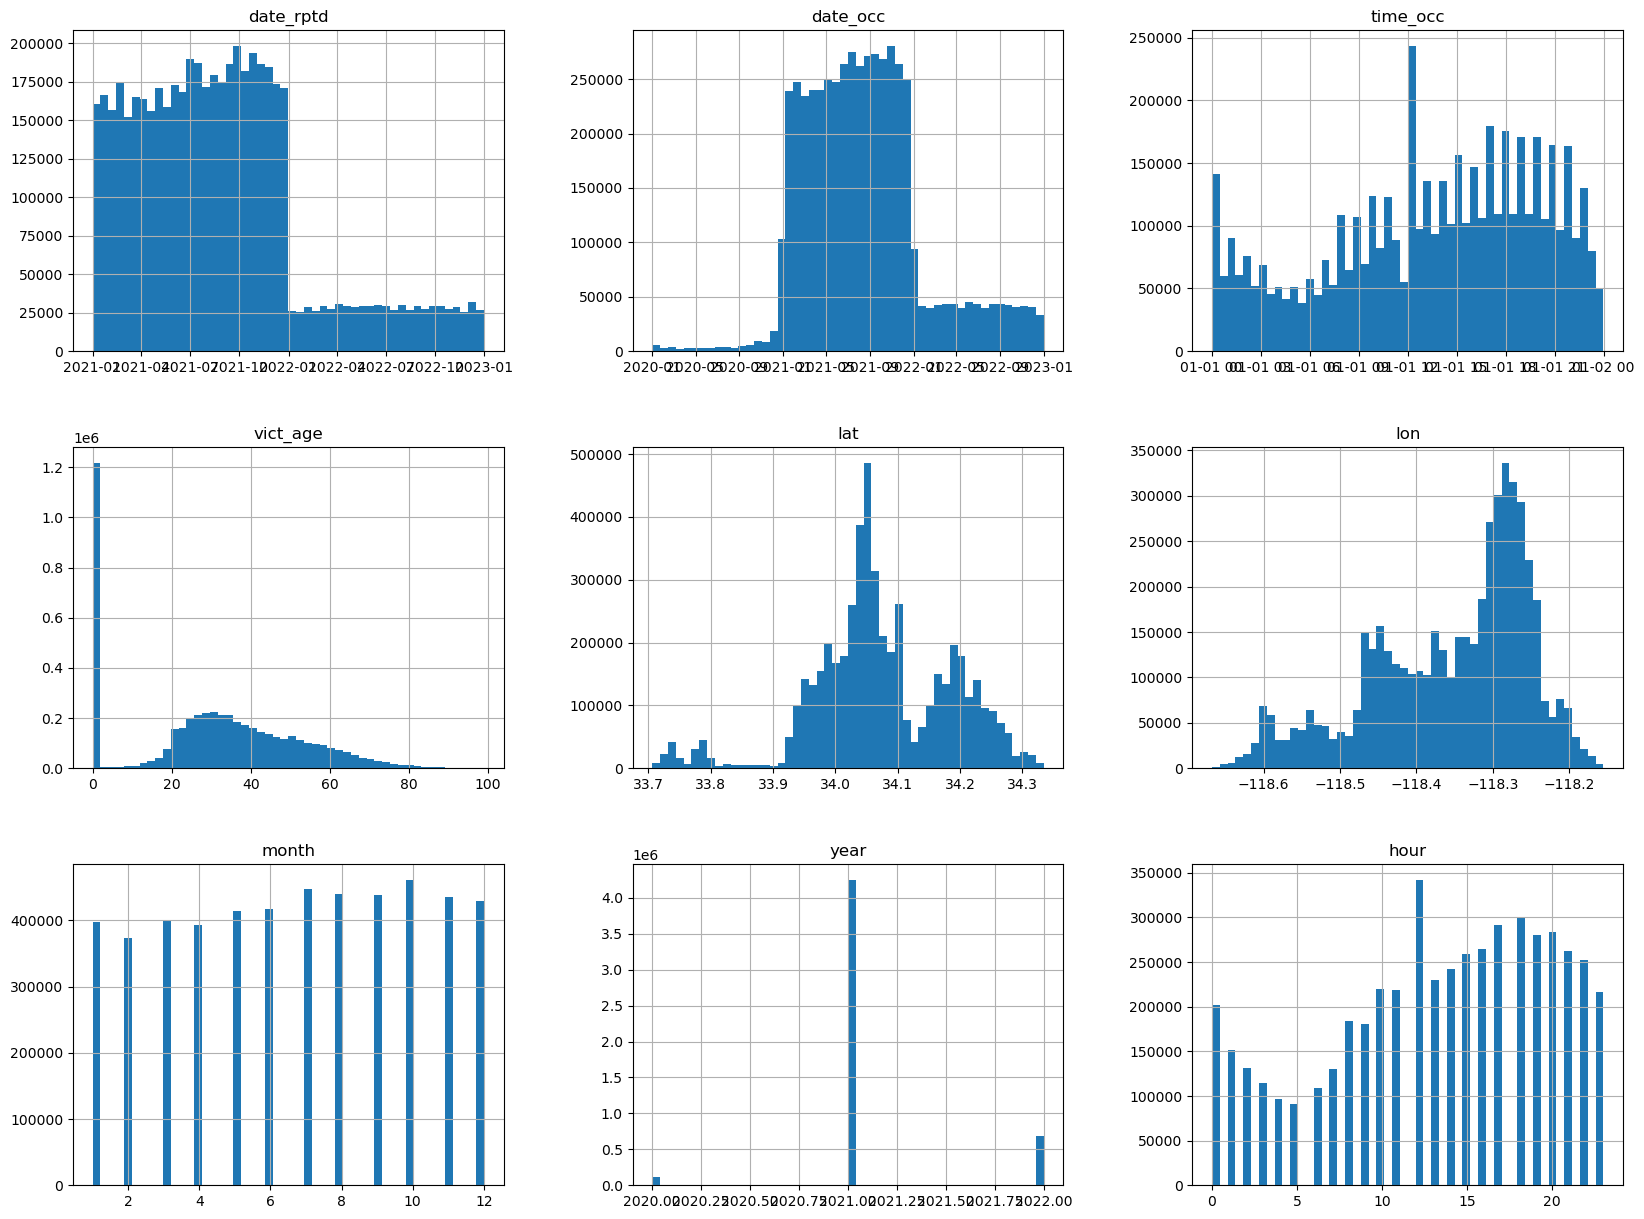

In [20]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [21]:
# Statistical summary for numerical data
print(df.describe())

           vict_age           lat           lon         month          year  \
count  5.048124e+06  5.048124e+06  5.048124e+06  5.048124e+06  5.048124e+06   
mean   3.005036e+01  3.407350e+01 -1.183547e+02  6.665720e+00  2.021114e+03   
std    2.166093e+01  1.113110e-01  1.040553e-01  3.423220e+00  3.808599e-01   
min    0.000000e+00  3.370610e+01 -1.186676e+02  1.000000e+00  2.020000e+03   
25%    1.300000e+01  3.401450e+01 -1.184303e+02  4.000000e+00  2.021000e+03   
50%    3.100000e+01  3.405920e+01 -1.183238e+02  7.000000e+00  2.021000e+03   
75%    4.500000e+01  3.416290e+01 -1.182750e+02  1.000000e+01  2.021000e+03   
max    9.900000e+01  3.433430e+01 -1.181554e+02  1.200000e+01  2.022000e+03   

               hour  
count  5.048124e+06  
mean   1.323212e+01  
std    6.538382e+00  
min    0.000000e+00  
25%    9.000000e+00  
50%    1.400000e+01  
75%    1.900000e+01  
max    2.300000e+01  


### Binarization

In [22]:
# Converting 0 to a separate category
df['vict_age_category'] = df['vict_age'].apply(lambda x: 'Unknown' if x == 0 else x)

In [23]:
df['vict_age_bin'] = df['vict_age'].apply(lambda x: 1 if x > 50 else 0)


In [24]:
print(df.head())

                        _id      dr_no  date_rptd   date_occ  \
0  6560da1421e317d69e7a32dd  211916029 2021-11-26 2020-11-30   
1  6560da1421e317d69e7a32de  210916801 2021-11-22 2020-11-19   
2  6560da1421e317d69e7a32df  211014725 2021-11-18 2020-12-28   
3  6560da1421e317d69e7a32e0  211015072 2021-11-29 2020-11-01   
4  6560da1421e317d69e7a32e1  210816993 2021-11-24 2020-04-28   

             time_occ area    area_name rpt_dist_no part_1_2 crm_cd  ...  \
0 1900-01-01 07:30:00   19      Mission        1916        2    626  ...   
1 1900-01-01 12:00:00    9     Van Nuys         932        2    354  ...   
2 1900-01-01 00:01:00   10  West Valley        1045        2    354  ...   
3 1900-01-01 12:00:00   10  West Valley        1043        2    354  ...   
4 1900-01-01 01:00:00    8      West LA         859        2    354  ...   

  crm_cd_2 cross_street  crm_cd_3 crm_cd_4 day_of_week month  year hour  \
0      NaN      Unknown       NaN      NaN      Monday    11  2020    7   
1      N

### Discretization

In [25]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'

# Creating the season column
df['season'] = df['month'].apply(get_season)

print(df)

                              _id      dr_no  date_rptd   date_occ  \
0        6560da1421e317d69e7a32dd  211916029 2021-11-26 2020-11-30   
1        6560da1421e317d69e7a32de  210916801 2021-11-22 2020-11-19   
2        6560da1421e317d69e7a32df  211014725 2021-11-18 2020-12-28   
3        6560da1421e317d69e7a32e0  211015072 2021-11-29 2020-11-01   
4        6560da1421e317d69e7a32e1  210816993 2021-11-24 2020-04-28   
...                           ...        ...        ...        ...   
5079139  657de626358531e3ffdb5e04  211421071 2021-11-07 2021-11-07   
5079140  657de626358531e3ffdb5e05  210516671 2021-12-01 2021-12-01   
5079141  657de626358531e3ffdb5e06  210217231 2021-11-06 2021-11-05   
5079142  657de626358531e3ffdb5e07  210312887 2021-07-12 2021-07-12   
5079143  657de626358531e3ffdb5e08  212005847 2021-02-22 2021-02-22   

                   time_occ area    area_name rpt_dist_no part_1_2 crm_cd  \
0       1900-01-01 07:30:00   19      Mission        1916        2    626   
1    

In [26]:
print(df.dtypes)

_id                          object
dr_no                        object
date_rptd            datetime64[ns]
date_occ             datetime64[ns]
time_occ             datetime64[ns]
area                       category
area_name                  category
rpt_dist_no                category
part_1_2                   category
crm_cd                     category
crm_cd_desc                  object
mocodes                      object
vict_age                    float64
vict_sex                   category
vict_descent               category
premis_cd                  category
premis_desc                category
weapon_used_cd             category
weapon_desc                category
status                     category
status_desc                category
crm_cd_1                   category
location                     object
lat                         float64
lon                         float64
crm_cd_2                   category
cross_street                 object
crm_cd_3                   c

In [28]:
from bson import ObjectId

def convert_objectid_to_str(value):
    if isinstance(value, ObjectId):
        return str(value)
    return value

chunk_size = 10000
chunks = []

for i in range(0, df.shape[0], chunk_size):
    current_chunk = df[i:i + chunk_size].applymap(convert_objectid_to_str)
    chunks.append(current_chunk)
    print(f"Processed chunk with size: {current_chunk.shape[0]}")

df = pd.concat(chunks, ignore_index=True)

Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed chunk with size: 10000
Processed 

### Loading into PostgreSQL (Batch Insertion)

In [29]:
from sqlalchemy import create_engine
import pandas as pd
import psycopg2
from sqlalchemy.exc import SQLAlchemyError

# PostgreSQL Connection
db_user = 'postgres'
db_password = 'root'
db_host = 'localhost'
db_port = '5432'
db_name = 'crimedata'

# Creating SQLAlchemy Engine
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

try:
   
    chunksize = 1000  

    # Inserting DataFrame into PostgreSQL using chunk insertion / batch insertion
    for i in range(0, len(df), chunksize):
        df.iloc[i:i + chunksize].to_sql('crime', engine, if_exists='replace' if i == 0 else 'append', index=False)
        print(f"Inserted chunk {i // chunksize + 1}/{len(df) // chunksize + 1}")

    print("DataFrame is successfully stored in the database.")

except SQLAlchemyError as e:
    print("Error occurred while storing data in PostgreSQL:", e)
except Exception as e:
    print("An unexpected error occurred:", e)

Inserted chunk 1/5049
Inserted chunk 2/5049
Inserted chunk 3/5049
Inserted chunk 4/5049
Inserted chunk 5/5049
Inserted chunk 6/5049
Inserted chunk 7/5049
Inserted chunk 8/5049
Inserted chunk 9/5049
Inserted chunk 10/5049
Inserted chunk 11/5049
Inserted chunk 12/5049
Inserted chunk 13/5049
Inserted chunk 14/5049
Inserted chunk 15/5049
Inserted chunk 16/5049
Inserted chunk 17/5049
Inserted chunk 18/5049
Inserted chunk 19/5049
Inserted chunk 20/5049
Inserted chunk 21/5049
Inserted chunk 22/5049
Inserted chunk 23/5049
Inserted chunk 24/5049
Inserted chunk 25/5049
Inserted chunk 26/5049
Inserted chunk 27/5049
Inserted chunk 28/5049
Inserted chunk 29/5049
Inserted chunk 30/5049
Inserted chunk 31/5049
Inserted chunk 32/5049
Inserted chunk 33/5049
Inserted chunk 34/5049
Inserted chunk 35/5049
Inserted chunk 36/5049
Inserted chunk 37/5049
Inserted chunk 38/5049
Inserted chunk 39/5049
Inserted chunk 40/5049
Inserted chunk 41/5049
Inserted chunk 42/5049
Inserted chunk 43/5049
Inserted chunk 44/50

### Retrieving data from PostgreSQL

In [30]:
try:
    df_retrieved = pd.read_sql('crime', engine)
    print("DataFrame is successfully retrieved from the database.")
except SQLAlchemyError as e:
    print("Error occurred while retrieving data from PostgreSQL:", e)
except Exception as e:
    print("An unexpected error occurred:", e)


DataFrame is successfully retrieved from the database.


In [31]:
df_retrieved.head()

,_id,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,...,cross_street,crm_cd_3,crm_cd_4,day_of_week,month,year,hour,vict_age_category,vict_age_bin,season
0,6560da1421e317d69e7a32dd,211916029,2021-11-26,2020-11-30,1900-01-01 07:30:00,19,Mission,1916,2,626,...,Unknown,NaN,NaN,Monday,11,2020,7,24.0,0,Autumn
1,6560da1421e317d69e7a32de,210916801,2021-11-22,2020-11-19,1900-01-01 12:00:00,9,Van Nuys,932,2,354,...,Unknown,NaN,NaN,Thursday,11,2020,12,46.0,0,Autumn
2,6560da1421e317d69e7a32df,211014725,2021-11-18,2020-12-28,1900-01-01 00:01:00,10,West Valley,1045,2,354,...,Unknown,NaN,NaN,Monday,12,2020,0,46.0,0,Winter
3,6560da1421e317d69e7a32e0,211015072,2021-11-29,2020-11-01,1900-01-01 12:00:00,10,West Valley,1043,2,354,...,Unknown,NaN,NaN,Sunday,11,2020,12,34.0,0,Autumn
4,6560da1421e317d69e7a32e1,210816993,2021-11-24,2020-04-28,1900-01-01 01:00:00,8,West LA,859,2,354,...,Unknown,NaN,NaN,Tuesday,4,2020,1,27.0,0,Spring


In [32]:
df_retrieved.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5048124 entries, 0 to 5048123
Data columns (total 36 columns):
 #   Column             Dtype         
---  ------             -----         
 0   _id                object        
 1   dr_no              object        
 2   date_rptd          datetime64[ns]
 3   date_occ           datetime64[ns]
 4   time_occ           datetime64[ns]
 5   area               int64         
 6   area_name          object        
 7   rpt_dist_no        int64         
 8   part_1_2           int64         
 9   crm_cd             int64         
 10  crm_cd_desc        object        
 11  mocodes            object        
 12  vict_age           float64       
 13  vict_sex           object        
 14  vict_descent       object        
 15  premis_cd          float64       
 16  premis_desc        object        
 17  weapon_used_cd     float64       
 18  weapon_desc        object        
 19  status             object        
 20  status_desc        objec

In [33]:
df_retrieved['month'] = df_retrieved['month'].astype(int)
df_retrieved['year'] = df_retrieved['year'].astype(int)

# Grouping the data by month across all years
monthly_crimes = df_retrieved.groupby('month').size()

### Visualisations

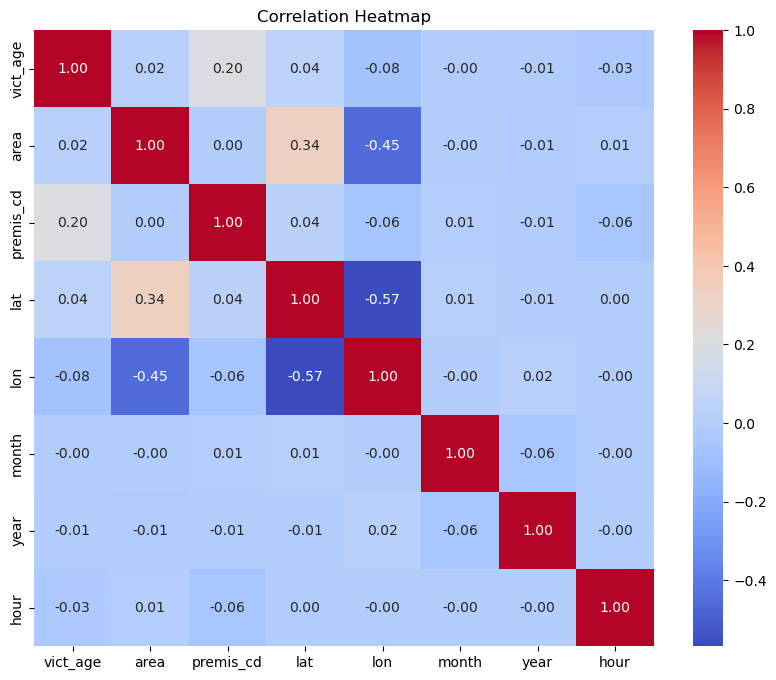

In [34]:
numerical_cols = ['vict_age', 'area', 'premis_cd', 'lat', 'lon', 'month', 'year', 'hour']
corr_matrix = df[numerical_cols].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

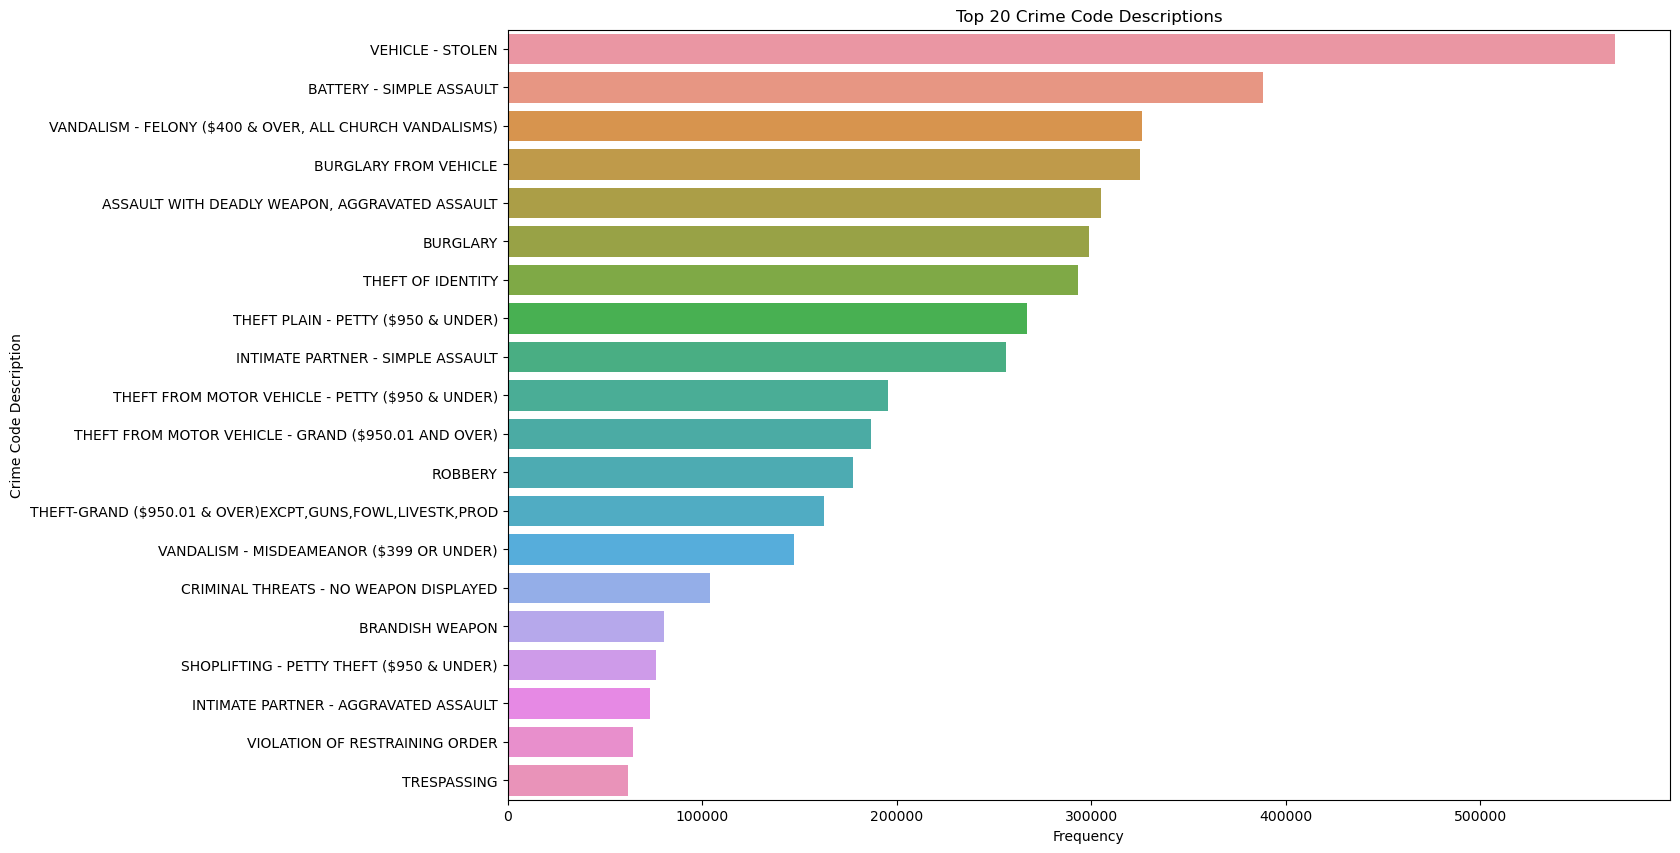

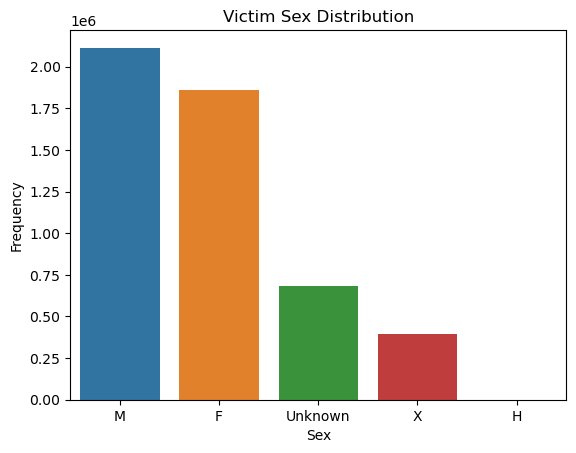

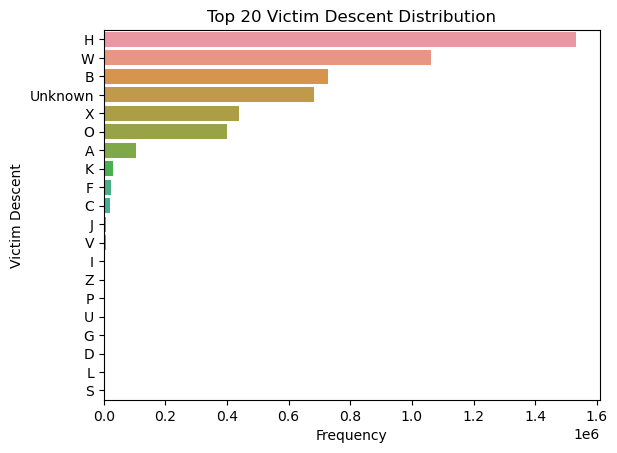

In [35]:
# Setting the overall size of the figure
plt.figure(figsize=(15, 10))

# Top 20 Crime Code Descriptions
top_n = df_retrieved['crm_cd_desc'].value_counts().head(20)
sns.barplot(y=top_n.index, x=top_n.values)
plt.title('Top 20 Crime Code Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Crime Code Description')
plt.show()

# Victim Sex Distribution
sns.countplot(x='vict_sex', data=df_retrieved, order=df_retrieved['vict_sex'].value_counts().index)
plt.title('Victim Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.show()

# Victim Descent Distribution
top_descent = df_retrieved['vict_descent'].value_counts().head(20)  # Adjust N as needed
sns.barplot(y=top_descent.index, x=top_descent.values)
plt.title('Top 20 Victim Descent Distribution')
plt.xlabel('Frequency')
plt.ylabel('Victim Descent')
plt.show()

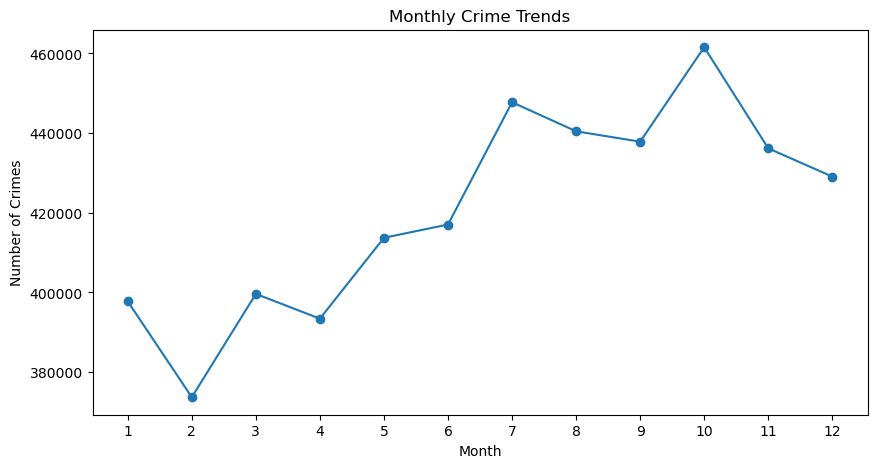

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_crimes.index, monthly_crimes.values, marker='o')

plt.title('Monthly Crime Trends')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(range(1, 13)) 
plt.ticklabel_format(style='plain', axis='y') 

plt.show()

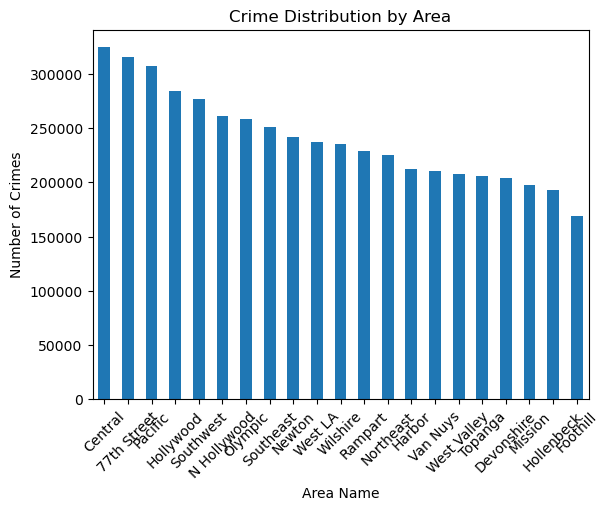

In [37]:
# Distribution by Area
df_retrieved['area_name'].value_counts().plot(kind='bar')
plt.title('Crime Distribution by Area')
plt.ylabel('Number of Crimes')
plt.xlabel('Area Name')
plt.xticks(rotation=45)
plt.show()


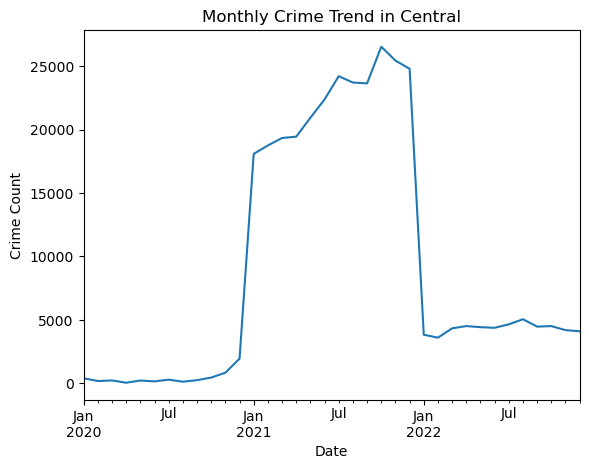

In [38]:
df[df['area_name'] == 'Central'].set_index('date_occ').resample('M').size().plot()
plt.title('Monthly Crime Trend in Central')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.show()

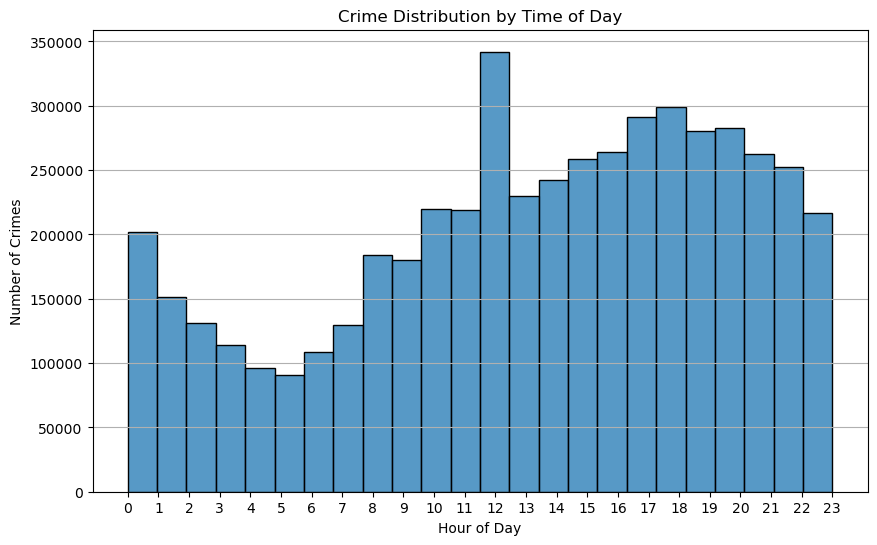

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(df_retrieved['hour'], bins=24, kde=False)
plt.title('Crime Distribution by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

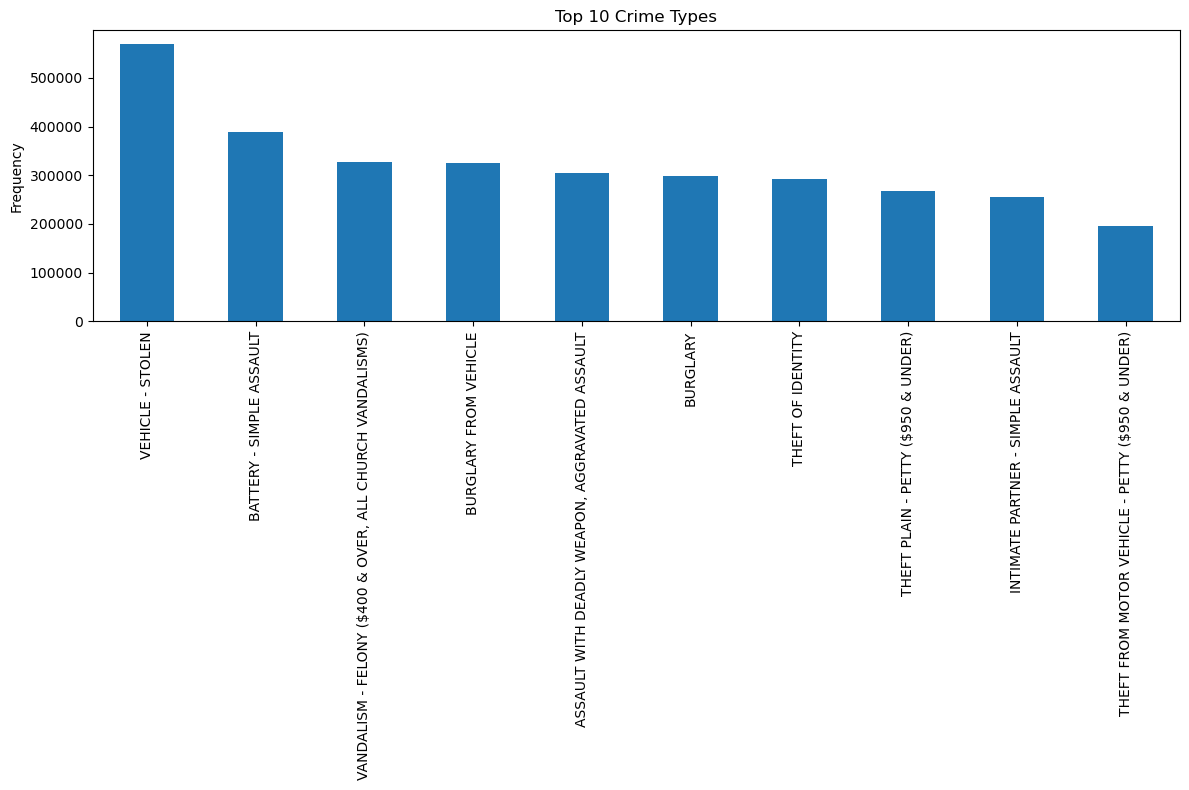

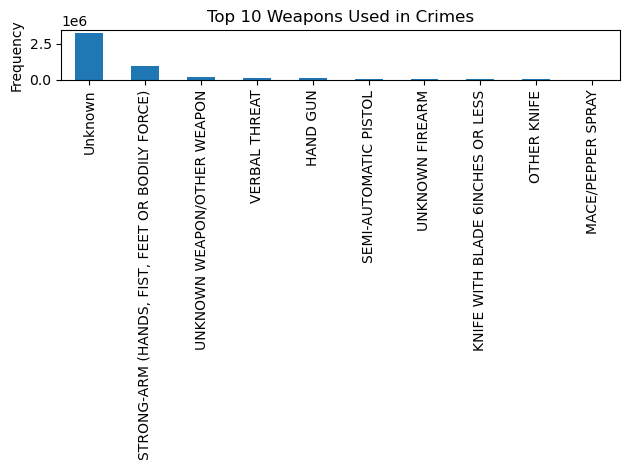

In [40]:
# Adjust the figure size
plt.figure(figsize=(12, 8))

# Plotting Top 10 Crime Types
df_retrieved['crm_cd_desc'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Crime Types')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the x-axis labels to 90 degrees for more space
plt.tight_layout()  # Adjust the layout to fit the figure size
plt.show()

# Plotting Top 10 Weapons Used in Crimes
df_retrieved['weapon_desc'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Weapons Used in Crimes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the x-axis labels to 90 degrees for more space
plt.tight_layout()  # Adjust the layout to fit the figure size
plt.show()

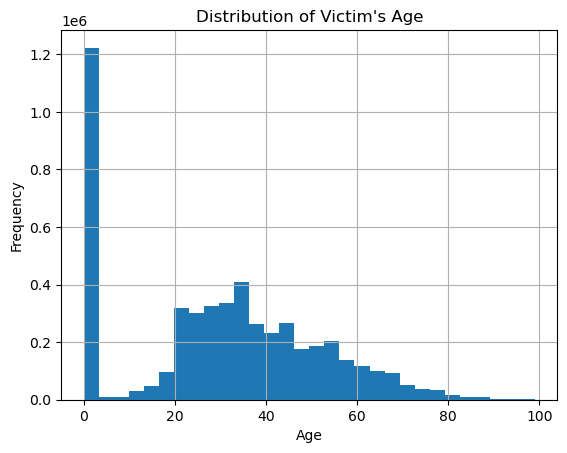

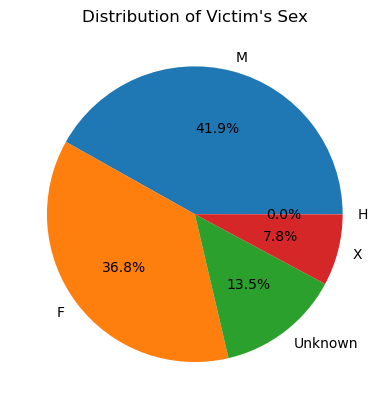

In [41]:
# Victim's Age Distribution
df_retrieved['vict_age'].hist(bins=30)
plt.title('Distribution of Victim\'s Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Victim's Sex Distribution
df_retrieved['vict_sex'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Victim\'s Sex')
plt.ylabel('')
plt.show()

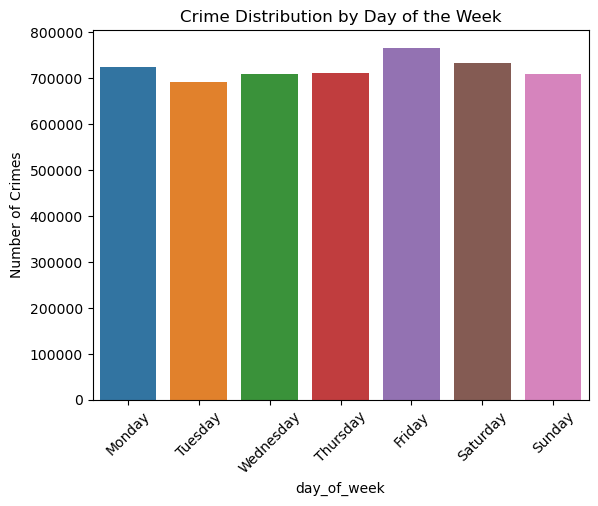

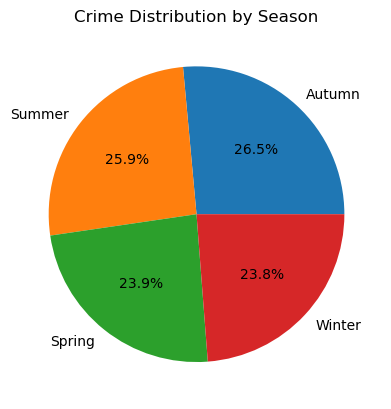

In [42]:
# Day of the Week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(data=df_retrieved, x='day_of_week', order=day_order)
plt.title('Crime Distribution by Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.show()

# Season
df_retrieved['season'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Crime Distribution by Season')
plt.ylabel('')
plt.show()